In [1]:
from __future__ import division
from __future__ import print_function

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/home/yuji/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/')

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist.train.images.shape

(55000, 784)

In [5]:
def plot_digits(*args):
    indices = np.array(list(args))
    n = len(indices)
    fig, axes =  plt.subplots(ncols=n, figsize=(n, 1))
    for i in range(n):
        ax = axes.flatten()[i]
        img = mnist.train.images[indices[i]].reshape(28, 28)
        label = mnist.train.labels[indices[i]]
        ax.set_title('Label: {}'.format(label))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

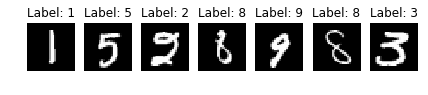

In [6]:
plot_digits(12, 28, 13, 42, 558, 78, 12333)

In [7]:
mnist.train.labels.shape

(55000,)

In [8]:
mnist.train.labels[:10]

array([7, 3, 4, 6, 1, 8, 1, 0, 9, 8], dtype=uint8)

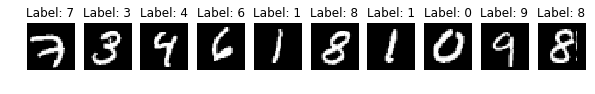

In [9]:
plot_digits(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

In [11]:
x_train = mnist.train.images
y_train = mnist.train.labels

x_test = mnist.test.images
y_test = mnist.test.labels

In [17]:
# input data
x = tf.placeholder(tf.float32, [None, 784])

# correct labels
y = tf.placeholder(tf.int64, [None, 10])